## Download model

In [4]:
!spell ls runs/552/checkpoints/

1007177… Dec 11 23:49   model_1.pth
1007177… Dec 11 23:49   model_10.pth
1007177… Dec 11 23:49   model_11.pth
1007177… Dec 11 23:49   model_12.pth
1007177… Dec 11 23:49   model_13.pth
1007177… Dec 11 23:49   model_14.pth
1007177… Dec 11 23:49   model_15.pth
1007177… Dec 11 23:49   model_16.pth
1007177… Dec 11 23:49   model_2.pth
1007177… Dec 11 23:49   model_3.pth
1007177… Dec 11 23:49   model_4.pth
1007177… Dec 11 23:49   model_5.pth
1007177… Dec 11 23:49   model_6.pth
1007177… Dec 11 23:49   model_7.pth
1007177… Dec 11 23:49   model_8.pth
1007177… Dec 11 23:49   model_9.pth


In [9]:
!spell cp runs/552/checkpoints/model_16.pth /spell/models/checkpoints/

✔ Copied 1 files.m


## Get model and test dataloader

In [11]:
# !pip install fastai

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.tensorboard import SummaryWriter

from fastai.layers import AdaptiveConcatPool2d, Flatten
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import numpy as np
import pandas as pd
from PIL import Image

import os
import io
import zipfile


LABELS = '/spell/datasets/working/train.csv'
OUT_TRAIN = '/spell/datasets/working/train.zip'
OUT_MASKS = '/spell/datasets/working/masks.zip'
NUM_EPOCHS = 16
BATCH_SIZE = 16
TRAIN_TEST_SPLIT = 0.8


##############
# DATALOADER #
##############

def get_train_test_split():
    # NOTE(aleksey): the DataFrame contains 100 entries which are mysteriously absent from
    # the train set. Here we filter these out here.
    with zipfile.ZipFile(OUT_TRAIN) as zf_train:
        files = [item.filename for item in zf_train.infolist()]
        files = [f[:32] for f in files]
        files = set(files)

        df = pd.read_csv(LABELS).set_index('image_id')
        df = df.loc[files]
    df = df.reset_index()
    train_df = df.sample(round(len(df) * TRAIN_TEST_SPLIT))
    test_df = df.loc[df.index.difference(train_df.index)]
    return train_df, test_df


class PandaDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.image_zf = zipfile.ZipFile(OUT_TRAIN)
        self.mask_zf = zipfile.ZipFile(OUT_MASKS)

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        X_id = self.df.iloc[idx, 0]
        # The target variable is the isup_score, which is a value 0 through 5.
        # The moodel predicts six values per class (a la softmax).
        y = torch.tensor(self.df.iloc[idx].isup_grade)
        tile_img_tensors, tile_mask_tensors = [], []

        for tile_id in range(0, 16):
            fd = self.image_zf.open(f"{X_id}_{tile_id}.png")
            tile_img_bytes = fd.read()
            fd.close()
            
            tile_img = Image.open(io.BytesIO(tile_img_bytes))
            tile_img_arr = np.array(tile_img)
            tile_img_arr.astype(np.float)
            
            fd = self.mask_zf.open(f"{X_id}_{tile_id}.png")
            tile_mask_bytes = fd.read()
            fd.close()
            
            tile_mask = Image.open(io.BytesIO(tile_mask_bytes))
            tile_mask_arr = np.array(tile_mask)
            
            tile_img_tensor = torch.tensor(tile_img_arr, dtype=torch.float).permute(2, 0, 1)
            tile_img_tensor = transforms.Normalize(
                mean=tile_img_tensor_means, std=tile_img_tensor_stds
            )(tile_img_tensor)

            tile_mask_tensor = torch.tensor(tile_mask_arr, dtype=torch.float)[np.newaxis, ...]
            tile_mask_tensor = transforms.Normalize(
                mean=(tile_mask_tensor_mean), std=(tile_mask_tensor_std)
            )(tile_mask_tensor)
            
            tile_img_tensors.append(tile_img_tensor)
            tile_mask_tensors.append(tile_mask_tensor)
        
        return torch.cat(tile_img_tensors, dim=1), torch.cat(tile_img_tensors, dim=1), y


#########
# MODEL #
#########

# NOTE(aleksey): these magic values are used by torchvision.transforms.Normalize.
def estimate_mean_and_std(zf_path, n_samples=1000):
    def calculate_mean_and_std(img_arr):
        return np.mean(img_arr, axis=(0, 1)), np.std(img_arr, axis=(0, 1))

    all_per_channel_means = []
    all_per_channel_stds = []
    
    with zipfile.ZipFile(zf_path) as zf:
        for img_info in np.random.choice(zf.infolist(), n_samples):
            img_fn = img_info.filename
            with zf.open(img_fn) as fp:
                img = Image.open(io.BytesIO(fp.read()))
                img_arr = np.array(img)
                per_channel_means, per_channel_stds = calculate_mean_and_std(img_arr)
                all_per_channel_means.append(per_channel_means)
                all_per_channel_stds.append(per_channel_stds)
    
    estimated_channelwide_means = np.stack(all_per_channel_means).mean(axis=0)
    estimated_channelwide_stds = np.stack(all_per_channel_stds).mean(axis=0)
    return estimated_channelwide_means, estimated_channelwide_stds

tile_img_tensor_means, tile_img_tensor_stds = estimate_mean_and_std(OUT_TRAIN)
tile_mask_tensor_mean, tile_mask_tensor_std = estimate_mean_and_std(OUT_MASKS)

# NOTE(aleksey): the model uses a Mish() module as part of its architecture. In the original
# Kaggle kernel this model is sourced from the mish_activation package. I could not determine
# the origin of this module, but inspecting the module in a Kaggle notebook (via import
# mish_activation; mish_activation??) reveals that the activation definition is a simple flat
# file. I've gone ahead and copied that to here.
class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * torch.tanh(F.softplus(x))   # x * tanh(ln(1 + exp(x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        sigmoid = torch.sigmoid(x)
        tanh_sp = torch.tanh(F.softplus(x)) 
        return grad_output * (tanh_sp + x * sigmoid * (1 - tanh_sp * tanh_sp))

class Mish(nn.Module):
    def forward(self, x):
        return MishFunction.apply(x)

def to_Mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            to_Mish(child)


class PandaModel(nn.Module):
    # NOTE(aleksey): n=6 because the value we are trying to predict is an ordinal categorical
    # with 6 possible values.
    def __init__(self, arch='resnext50_32x4d_ssl', n=6, pre=True):
        super().__init__()
        m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', arch)
        self.enc = nn.Sequential(*list(m.children())[:-2])
        nc = list(m.children())[-1].in_features
        self.head = nn.Sequential(
            # TODO: replace these fastaia layers with torch ones
            AdaptiveConcatPool2d(),
            Flatten(),
            nn.Linear(2 * nc, 512),
            Mish(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, n)
        )
        
    def forward(self, *x):
        shape = x[0].shape
        n = len(x)
        x = torch.stack(x, 1).view(-1, shape[1], shape[2], shape[3])
        
        #x: bs*N x 3 x 128 x 128
        x = self.enc(x)
        
        #x: bs*N x C x 4 x 4
        shape = x.shape
        #concatenate the output for tiles into a single map
        x = (x.view(-1, n, shape[1], shape[2], shape[3])
             .permute(0, 2, 1, 3, 4)
             .contiguous()
             .view(-1, shape[1], shape[2] * n, shape[3]))

        #x: bs x C x N*4 x 4
        x = self.head(x)
        #x: bs x n
        return x

In [5]:
_, test_df = get_train_test_split()
test_dataset = PandaDataset(test_df)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [2]:
from torch.nn.utils import prune
import numpy as np

def get_model():
    """
    Loads the model from checkpoint.
    """
    model = PandaModel()
    model.load_state_dict(torch.load("/spell/models/checkpoints/model_16.pth"))
    model.cuda()
    model.eval()
    return model

def prune_model(model, layer_type, proportion):
    """
    Prunes the model.
    """
    # NOTE(aleksey): modules in a Sequential module have names like 4.1.conv3.
    for name, module in model.enc.named_modules():
        if isinstance(module, layer_type):
            prune.l1_unstructured(module, 'weight', proportion)
            prune.remove(module, 'weight')
    return model

def get_model_val_loss(model):
    """
    Returns the mean validation loss for the input model.
    """
    criterion = nn.CrossEntropyLoss()
    losses = []
    
    with torch.no_grad():
        for i, (X, _, y) in enumerate(iter(test_dataloader)):
            X = X.cuda()
            y = y.cuda()
            
            X_pred = model(X)
            loss = criterion(X_pred, y)
            curr_loss = loss.item()
            losses.append(curr_loss)

    return np.mean(losses)

## Pruning inference

In [38]:
model = get_model()

Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


In [39]:
%time get_model_val_loss(model)

CPU times: user 2min 21s, sys: 6.66 s, total: 2min 27s
Wall time: 1min 32s


1.2234920516158596

In [40]:
model = get_model()
model = prune_model(model, nn.Conv2d, 0.1)

Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


In [41]:
%time get_model_val_loss(model)

CPU times: user 2min 21s, sys: 6.45 s, total: 2min 28s
Wall time: 1min 33s


1.2327416051517834

In [42]:
model = get_model()
model = prune_model(model, nn.Conv2d, 0.2)

Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


In [43]:
%time get_model_val_loss(model)

CPU times: user 2min 21s, sys: 6.66 s, total: 2min 28s
Wall time: 1min 33s


1.25750197944316

In [44]:
model = get_model()
model = prune_model(model, nn.Conv2d, 0.3)

Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


In [45]:
%time get_model_val_loss(model)

CPU times: user 2min 22s, sys: 5.3 s, total: 2min 27s
Wall time: 1min 32s


1.195499126658295

In [46]:
model = get_model()
model = prune_model(model, nn.Conv2d, 0.4)

Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


In [47]:
%time get_model_val_loss(model)

CPU times: user 2min 21s, sys: 5.04 s, total: 2min 26s
Wall time: 1min 32s


1.2042179626948906

In [48]:
model = get_model()
model = prune_model(model, nn.Conv2d, 0.5)

Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


In [49]:
%time get_model_val_loss(model)

CPU times: user 2min 22s, sys: 5.17 s, total: 2min 27s
Wall time: 1min 32s


1.2962080136393055

In [50]:
model = get_model()
model = prune_model(model, nn.Conv2d, 0.6)

Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


In [51]:
%time get_model_val_loss(model)

CPU times: user 2min 21s, sys: 5.24 s, total: 2min 26s
Wall time: 1min 31s


2.3007163351232354

In [52]:
model = get_model()
model = prune_model(model, nn.Conv2d, 0.7)

Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


In [53]:
%time get_model_val_loss(model)

CPU times: user 2min 20s, sys: 5.22 s, total: 2min 25s
Wall time: 1min 31s


3.7908382162903296

In [54]:
model = get_model()
model = prune_model(model, nn.Conv2d, 0.8)

Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


In [55]:
%time get_model_val_loss(model)

CPU times: user 2min 20s, sys: 5.08 s, total: 2min 25s
Wall time: 1min 31s


3.7908382162903296

As you can see, pruning does not immediately reduce model accuracy (we can get reasonably far before we start to see the model diverge), but it doesn't reduce inference time either.

In [7]:
def test_pruning_jobs(get_fn, prune_fn, eval_fn):
    losses = []
    
    print(f"Evaluating model with θ=0 pruning.")
    model = get_fn()
    unpruned_loss = eval_fn(model)
    losses.append((0, unpruned_loss))
    
    for i in range(1, 18):
        p = i * 0.05
        print(f"Evaluating model with θ={p} pruning.")
        model = get_fn()
        pruned_model = prune_fn(model, p)
        loss = eval_fn(pruned_model)
        losses.append((p, loss))
    
    return losses

prune_fn = lambda model, proportion: prune_model(model, nn.Conv2d, proportion)

In [8]:
%%time
losses = test_pruning_jobs(get_model, prune_fn, get_model_val_loss)
print(losses)

Evaluating model with θ=0 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.05 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.1 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.15000000000000002 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.2 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.25 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.30000000000000004 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.35000000000000003 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.4 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.45 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.5 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.55 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.6000000000000001 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.65 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.7000000000000001 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.75 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.8 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.8500000000000001 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


[(0, 1.2599949543223237), (0.05, 1.2633455287326465), (0.1, 1.2692795576471272), (0.15000000000000002, 1.2879794664455182), (0.2, 1.2935932590202852), (0.25, 1.2629090091495803), (0.30000000000000004, 1.2295169125903735), (0.35000000000000003, 1.2251191091808407), (0.4, 1.2340381452531526), (0.45, 1.331299302252856), (0.5, 1.3634718516559312), (0.55, 1.5885701897469433), (0.6000000000000001, 2.299563388932835), (0.65, 2.5253989732626714), (0.7000000000000001, 3.8075855618173424), (0.75, 4.721213411201131), (0.8, 7.21074643460187), (0.8500000000000001, 26.48252417824485)]
CPU times: user 41min 33s, sys: 1min 28s, total: 43min 2s
Wall time: 27min 17s


In [24]:
pd.DataFrame.assign

<function pandas.core.frame.DataFrame.assign(self, **kwargs) -> 'DataFrame'>

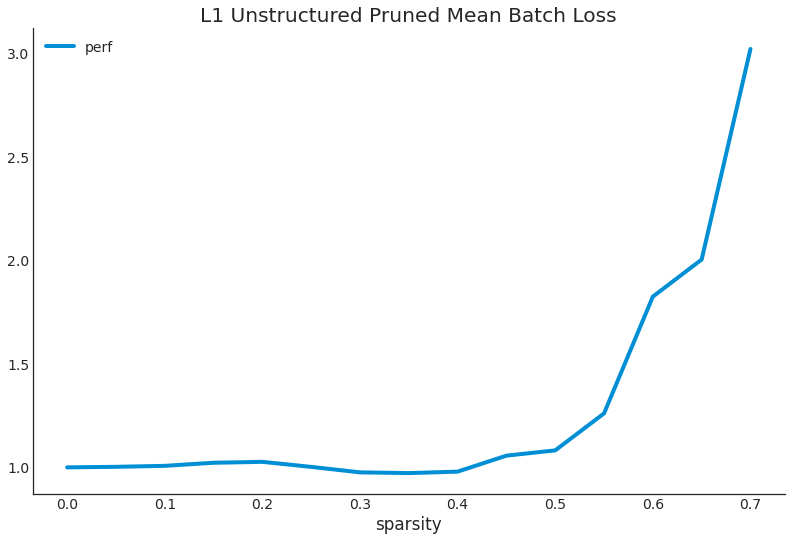

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')

import pandas as pd
(pd.DataFrame(losses, columns=['sparsity', 'loss'])
 .pipe(lambda df: df.assign(
     perf=(df.loss - pd.Series([losses[0][1]] * len(df))) / losses[0][1] + 1
 ))
 .head(15)
 .plot.line(x='sparsity', y='perf', figsize=(12, 8), title="L1 Unstructured Pruned Mean Batch Loss")
)
sns.despine()

In [55]:
def prune_model_l1_structured(model, layer_type, proportion):
    """
    Prunes the model.
    """
    # NOTE(aleksey): modules in a Sequential module have names like 4.1.conv3.
    for name, module in model.enc.named_modules():
        if isinstance(module, layer_type):
            prune.ln_structured(module, 'weight', proportion, n=1, dim=1)
            prune.remove(module, 'weight')
    return model

prune_fn = lambda model, proportion: prune_model_l1_structured(model, nn.Conv2d, proportion)

In [56]:
%%time
losses = test_pruning_jobs(get_model, prune_fn, get_model_val_loss)
print(losses)

Evaluating model with θ=0 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.05 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.1 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.15000000000000002 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.2 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.25 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.30000000000000004 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.35000000000000003 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.4 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.45 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.5 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.55 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.6000000000000001 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.65 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.7000000000000001 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.75 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.8 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.8500000000000001 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


[(0, 1.2599949543223237), (0.05, 1.2265391584598657), (0.1, 1.4497346313613835), (0.15000000000000002, 2.7092741637518913), (0.2, 4.5326409556648946), (0.25, 4.772459423903263), (0.30000000000000004, 5.701777506958354), (0.35000000000000003, 8.00228102460052), (0.4, 14.310866393826224), (0.45, 19.010703339721218), (0.5, 7.072856971711824), (0.55, 20.248330759279657), (0.6000000000000001, 37.9292118621595), (0.65, 51.34608421903668), (0.7000000000000001, 48.860263564369895), (0.75, 68.35477485078754), (0.8, 35.13974808201645), (0.8500000000000001, 42.69696310794715)]
CPU times: user 41min 27s, sys: 1min 17s, total: 42min 44s
Wall time: 27min 4s


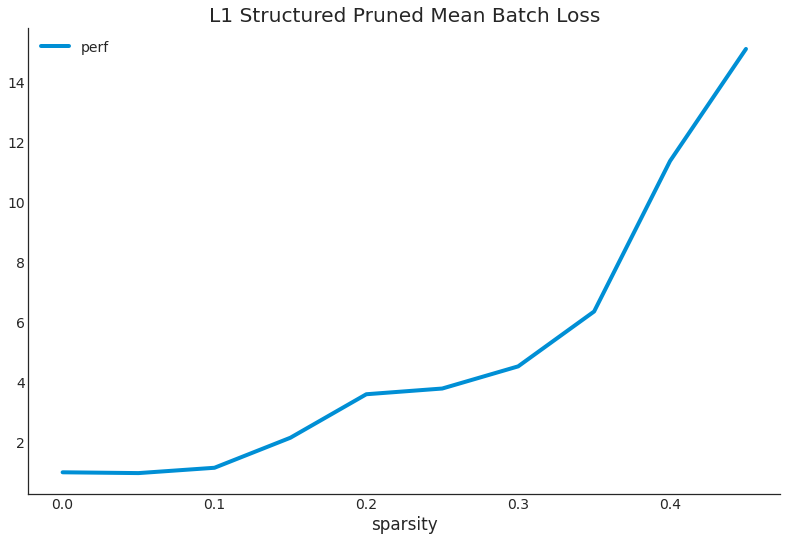

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')

import pandas as pd
(pd.DataFrame(losses, columns=['sparsity', 'loss'])
 .pipe(lambda df: df.assign(
     perf=(df.loss - pd.Series([losses[0][1]] * len(df))) / losses[0][1] + 1
 ))
 .head(10)
 .plot.line(x='sparsity', y='perf', figsize=(12, 8), title="L1 Structured Pruned Mean Batch Loss")
)
sns.despine()

In [63]:
model = prune_model(get_model(), nn.Conv2d, 0.5)

Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


In [64]:
%time get_model_val_loss(model)

CPU times: user 2min 20s, sys: 4.19 s, total: 2min 24s
Wall time: 1min 31s


1.3634718516559312

In [70]:
# Throws runtime error! to_sparse() not working on torch.stack

# def get_sparse_model_val_loss(model):
#     """
#     Returns the mean validation loss for the input model.
#     """
#     criterion = nn.CrossEntropyLoss()
#     losses = []
    
#     with torch.no_grad():
#         for i, (X, _, y) in enumerate(iter(test_dataloader)):
#             X = X.to_sparse().cuda()
#             y = y.to_sparse().cuda()
            
#             X_pred = model(X)
#             loss = criterion(X_pred, y)
#             curr_loss = loss.item()
#             losses.append(curr_loss)

#     return np.mean(losses)
#
# get_sparse_model_val_loss(model)

In [123]:
def prune_model_global_unstructured(model, layer_type, proportion):
    module_tups = []
    for module in model.modules():
        if isinstance(module, layer_type):
            module_tups.append((module, 'weight'))

    prune.global_unstructured(
        parameters=module_tups, pruning_method=prune.L1Unstructured,
        amount=proportion
    )
    for module, _ in module_tups:
        prune.remove(module, 'weight')
    return model

prune_fn = lambda model, proportion: prune_model_global_unstructured(model, nn.Conv2d, proportion)

In [124]:
%%time
losses = test_pruning_jobs(get_model, prune_fn, get_model_val_loss)
print(losses)

Evaluating model with θ=0 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.05 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.1 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.15000000000000002 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.2 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.25 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.30000000000000004 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.35000000000000003 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.4 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.45 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.5 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.55 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.6000000000000001 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.65 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.7000000000000001 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.75 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.8 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Evaluating model with θ=0.8500000000000001 pruning.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


[(0, 1.2599949543223237), (0.05, 1.2599682392496052), (0.1, 1.2596548904072156), (0.15000000000000002, 1.2625070954814102), (0.2, 1.2638700527675224), (0.25, 1.2585663930936293), (0.30000000000000004, 1.2643765752965754), (0.35000000000000003, 1.2678472056533352), (0.4, 1.270226574305332), (0.45, 1.2607451022574396), (0.5, 1.2691815549677068), (0.55, 1.255461210102746), (0.6000000000000001, 1.2621584110187762), (0.65, 1.2443837293169715), (0.7000000000000001, 1.2217888633410137), (0.75, 1.1931778811144107), (0.8, 1.2343535233627667), (0.8500000000000001, 1.4846959109559204)]
CPU times: user 41min 41s, sys: 1min 31s, total: 43min 13s
Wall time: 27min 23s


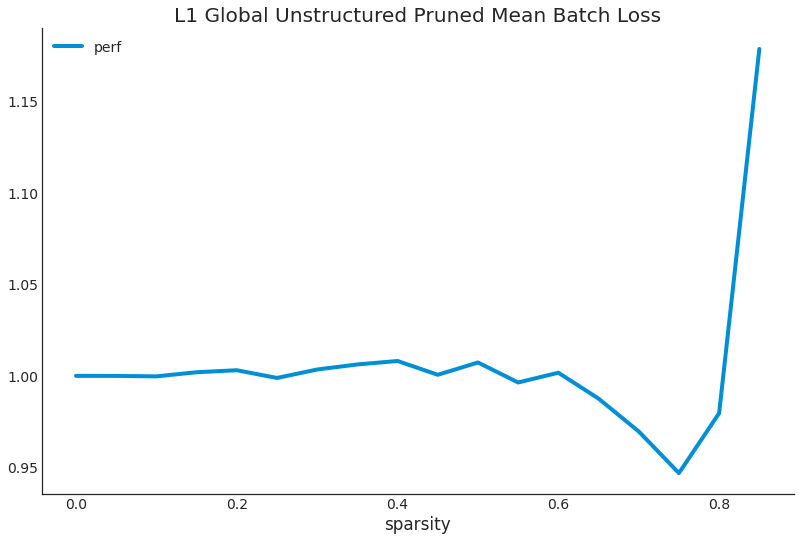

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')

import pandas as pd
(pd.DataFrame(losses, columns=['sparsity', 'loss'])
 .pipe(lambda df: df.assign(
     perf=(df.loss - pd.Series([losses[0][1]] * len(df))) / losses[0][1] + 1
 ))
 .plot.line(x='sparsity', y='perf', figsize=(12, 8), title="L1 Global Unstructured Pruned Mean Batch Loss")
)
sns.despine()

## Pruning model size

Uncompressed size is the same.

In [83]:
model = get_model()
torch.save(model.state_dict(), "/tmp/model.h5")

!du -h /tmp/model.h5

Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


97M	/tmp/model.h5


In [82]:
model = get_model()
model = prune_model(model, nn.Conv2d, 0.4)
torch.save(model.state_dict(), "/tmp/model.h5")

!du -h /tmp/model.h5

Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


97M	/tmp/model.h5


Compressed size is smaller.

In [96]:
model = get_model()
torch.save(model.state_dict(), "/tmp/model.h5")

!gzip -qf /tmp/model.h5
!du -h /tmp/model.h5.gz

Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


90M	/tmp/model.h5.gz


In [97]:
model = get_model()
model = prune_model(model, nn.Conv2d, 0.4)
torch.save(model.state_dict(), "/tmp/model.h5")

!gzip -qf /tmp/model.h5
!du -h /tmp/model.h5.gz

Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


65M	/tmp/model.h5.gz
